In [194]:
from __future__ import division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
from PIL import Image
from torch.autograd import Variable
import random
import math
from functools import reduce
from scipy import stats

import cv2
from glob import glob

import skimage
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
from skimage.color import rgb2grey, rgb2hsv, hsv2rgb, grey2rgb, rgba2rgb
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
import random
import math
from functools import reduce

import cv2
from glob import glob

import skimage
from skimage.io import imread
from skimage import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.util import invert
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from skimage.filters import gaussian

from skimage.morphology import erosion, dilation, binary_dilation, opening, closing, white_tophat
from skimage.morphology import disk

import sklearn
from skimage.morphology import label

import utils
from utils import show_images, plot_img_and_hist

In [175]:
transform = reload(transform)
utils = reload(utils)

In [602]:
#%pycat main.py

import os
import shutil
import torch
from torch.autograd import Variable
from tqdm import tqdm

def save_model(
        model,
        optimizer,
        stats,
        it,
        is_best=False,
        fname='model_save.pth.tar'):
    m_state_dict = model.state_dict()
    o_state_dict = optimizer.state_dict()

    torch.save({
        'it': it,
        'model_state_dict': m_state_dict,
        'optimizer_state_dict': o_state_dict,
        'stats': stats},
        fname)
    if is_best:
        print('new best: ', stats[-1])
        shutil.copyfile(fname, 'model_best.pth.tar')


def load_model(model, optimizer, fname='model_best.pth.tar'):

    if os.path.isfile(fname):
        checkpoint = torch.load(fname)
        it = checkpoint['it']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        stats = checkpoint['stats']
        print(
            "=> loaded checkpoint '{}' (iteration {})".format(
                fname, checkpoint['it']))
        return it, stats
    else:
        print("=> no checkpoint found at '{}'".format(fname))
        return None, None


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    cnt = 0
    for i, (img, (labels, labels_seg)) in enumerate(loader):
        img, labels_seg = Variable(img), Variable(labels_seg)
        outputs = model(img)
        loss = criterion(outputs, labels_seg)
        running_loss += loss.data[0]
        cnt = cnt + 1
    l = running_loss / cnt
    return l


def train(
        train_loader,
        valid_loader,
        model,
        criterion,
        optimizer,
        stats,
        epoch,
        eval_every,
        print_every,
        save_every):
    running_loss = 0.0
    cnt = 0
    global it, best_it, best_loss
    for it, (img, (labels, labels_seg)) in tqdm(enumerate(train_loader, it + 1)):
        img, labels_seg = Variable(img), Variable(labels_seg)
        
        model.train(True)

        outputs = model(img)
        loss = criterion(outputs, labels_seg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cnt = cnt + 1

        running_loss += loss.data[0]
        if cnt > 0 and it % eval_every == 0:

            l = validate(model, valid_loader, criterion)
            stats.append((it, running_loss / cnt, l))
            running_loss = 0.0

            if cnt > 0 and it % print_every == 0:
                print('[%d, %d]\ttrain loss: %.3f\tvalid loss: %.3f' %
                      (epoch, it, stats[-1][1], stats[-1][2]))
            if it % save_every == 0:
                is_best = False
                if best_loss > l:
                    best_loss = l
                    best_it = it
                    is_best = True
                    save_model(
                        model,
                        optimizer,
                        stats,
                        it,
                        is_best,
                        'model_save.pth.tar')
            cnt = 0
    return it, best_loss, best_it

def baseline(
        train_loader,
        valid_loader,
        criterion,
        it):
    
    m = 0.0
    cnt = 0.0
    for i, (img, (labels, labels_seg)) in enumerate(train_loader):
        if i > it:
            break
        m += labels_seg[0].sum()
        cnt += labels_seg[0].numel()
    m = m / cnt

    running_loss = 0.0
    
    cnt = 0
    for i, (img, (labels,labels_seg)) in enumerate(valid_loader):
        outputs = labels_seg.clone()        
        outputs = torch.clamp(outputs, m, m)
        img, labels = Variable(img), Variable(labels_seg)
        outputs = Variable(outputs)
    
        loss = criterion(outputs, labels_seg)

        running_loss += loss.data[0]
        cnt += 1

    return running_loss/cnt, m


def adjust_learning_rate(optimizer, epoch, lr0):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr0 * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr



Overwriting main.py


In [599]:
##%%writefile dataset.py
#%pycat dataset.py

from __future__ import division
import os
import torch
import pandas as pd
import numpy as np

import random
import math
from functools import reduce

from glob import glob

from torchvision import transforms, utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image

import skimage
from skimage import img_as_float, img_as_ubyte
from skimage.io import imread
from skimage.color import rgb2grey

import sklearn
from sklearn.model_selection import train_test_split as train_test_split_sk

import cv2


class NucleusDataset(Dataset):
    """Nucleus dataset."""

    @staticmethod
    def read_and_stack(in_img_list):
        return np.sum(np.stack([i*(imread(c_img)>0) for i, c_img in enumerate(in_img_list, 1)], 0), 0)
        #r = (reduce(
        #        np.bitwise_or, [
        #            np.asarray(Image.open(c_img)) for c_img in iter(in_img_list)])).astype(np.uint8)
        #r = r / r.max()
        return r

    @staticmethod
    def read_image(in_img_list):
        #img = img_as_float(rgb2hsv(rgba2rgb(io.imread(in_img_list[0]))))
        img = Image.open(in_img_list[0])
        return np.array(img.convert('RGB')), img.size

    @staticmethod
    def as_segmentation(img):
        return (img>0).astype(int)

    @staticmethod
    def is_inverted(img, invert_thresh_pd=10.0):
        img_grey = img_as_ubyte(rgb2grey(img))
        img_th = cv2.threshold(img_grey,0,255,cv2.THRESH_OTSU)[1]
        return np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))

    def __init__(
            self,
            root_dir=None,
            stage_name='stage1',
            group_name='train',
            transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.transform = transform

        if root_dir is None:
            return

        all_images = glob(
            os.path.join(
                root_dir,
                stage_name +
                '_*',
                '*',
                '*',
                '*'))
        
        img_df = pd.DataFrame({'path': all_images})

        def img_id(in_path): return in_path.split('/')[-3]

        def img_type(in_path): return in_path.split('/')[-2]

        def img_group(in_path): return in_path.split('/')[-4].split('_')[1]

        def img_stage(in_path): return in_path.split('/')[-4].split('_')[0]
        img_df['id'] = img_df['path'].map(img_id)
        img_df['type'] = img_df['path'].map(img_type)
        img_df['group'] = img_df['path'].map(img_group)
        img_df['stage'] = img_df['path'].map(img_stage)
        self.img_df = img_df

        data_df = img_df.query('group=="%s"' % group_name)
        data_rows = []
        group_cols = ['stage', 'id']
        for n_group, n_rows in data_df.groupby(group_cols):
            c_row = {
                col_name: col_value for col_name,
                col_value in zip(
                    group_cols,
                    n_group)}
            c_row['masks'] = n_rows.query('type == "masks"')[
                'path'].values.tolist()
            c_row['images'] = n_rows.query('type == "images"')[
                'path'].values.tolist()
            data_rows += [c_row]

        data_df = pd.DataFrame(data_rows)

        ret = data_df['images'].map(self.read_image)
        #(data_df['images'], data_df['format'], data_df['mode'], data_df['size']) = ([x[i] for x in ret] for i in range(4))
        (data_df['images'], data_df['size']) = ([x[i] for x in ret] for i in range(2))
    
        data_df['masks'] = data_df['masks'].map(
            self.read_and_stack).map(
            lambda x: x.astype(np.uint8))

        data_df['masks_seg'] = data_df['masks'].map(self.as_segmentation)
        data_df['inv'] = data_df['images'].map(self.is_inverted)

        self.data_df = data_df

        
    def __len__(self):
        return self.data_df.shape[0]

    
    def __getitem__(self, idx):

        sample = self.data_df["images"].iloc[idx]
        masks =  self.data_df["masks"].iloc[idx]
        masks_seg =  self.data_df["masks_seg"].iloc[idx]
        if self.transform:
            sample, masks, masks_seg = self.transform(sample, masks, masks_seg)

        return sample, (masks, masks_seg)
    
    
    def train_test_split(self, **options):
        """ Return a list of splitted indices from a DataSet.
        Indices can be used with DataLoader to build a train and validation set.

        Arguments:
            A Dataset
            A test_size, as a float between 0 and 1 (percentage split) or as an int (fixed number split)
            Shuffling True or False
            Random seed
        """
   
        df_train, df_test = train_test_split_sk(self.data_df, **options)
        dset_train = NucleusDataset(transform=self.transform)
        dset_train.data_df = df_train

        dset_test = NucleusDataset(transform=self.transform)
        dset_test.data_df = df_test

        return dset_train, dset_test


Overwriting dataset.py


In [95]:
import transform
from transform import random_rotate90_transform2
import torchvision
from torchvision.transforms import ToTensor, ToPILImage

#Note: for image and mask, there is no compatible solution that can use transforms.Compse(), see https://github.com/pytorch/vision/issues/9
#transformations = transforms.Compose([random_rotate90_transform2(),transforms.ToTensor(),])

def train_transform(img, mask, mask_seg):
    # HACK (make dims consistent, first one is channels)
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, 2)
    if len(mask_seg.shape) == 2:
        mask_seg = np.expand_dims(mask_seg, 2)
    img, mask, mask_seg = random_rotate90_transform2(0.5, img, mask, mask_seg)
    img = ToTensor()(img)
    mask = torch.from_numpy(np.transpose(mask, (2, 0, 1))).float()
    mask_seg = torch.from_numpy(np.transpose(mask_seg, (2, 0, 1))).float()
    return img, mask, mask_seg

dsb_data_dir = os.path.join('..', '..', 'input')
stage_name = 'stage1'
#dset = NucleusDataset(dsb_data_dir, stage_name,transform=train_transform)
dset.transform=train_transform
#dset_save = dset
#train_idx, valid_idx = train_valid_split(dset,test_size=0.05,random_seed=1,shuffle=True)
#train_sampler = SubsetRandomSampler(train_idx)
#valid_sampler = SubsetRandomSampler(valid_idx)
#train_loader = DataLoader(dset,batch_size=1,sampler=train_sampler,num_workers=4)
#valid_loader = DataLoader(dset,batch_size=1,sampler=valid_sampler,num_workers=4)

# hack: this image format (1388, 1040) occurs only ones, stratify complains .. 
dset.data_df = dset.data_df[dset.data_df['size'] != (1388, 1040)]

stratify = dset.data_df['images'].map(lambda x: '{}'.format(x.size))
train_dset, valid_dset = dset.train_test_split(test_size=0.05, random_state=1, shuffle=True, stratify=stratify)
train_loader = DataLoader(train_dset, batch_size=1,shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=1,shuffle=True)



In [ ]:
# summary of image formats
dset.data_df.groupby(['format','mode','size']).size()

In [ ]:
modes = dset.data_df['images'].map(lambda x: x.mode)
sizes = dset.data_df['images'].map(lambda x: x.size)
print np.unique(sizes)

In [600]:
#%%writefile architectures.py
#%pycat architectures.py

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1)

# class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)[source]


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

    
class ImgModDetector(nn.Module):
    def __init__(self):
        super(ImgModDetector, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 3, stride=1, kernel_size=1, padding=0))
        self.layer2 = nn.Sequential(
            nn.Conv2d(3, 10, stride=1, kernel_size=1, padding=0),
            nn.Sigmoid())
        self.fc = nn.Linear(10,3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        mx = nn.Sequential(nn.MaxPool2d((out.size()[-2],out.size()[-1])))
        out = mx(out).squeeze(-1).squeeze(-1)
        out = self.fc(out)
        
        # replicate to width x height
        out = out.unsqueeze(2).unsqueeze(2).expand(-1,-1,x.size()[-2],x.size()[-1])

        return out

class Coarse(nn.Module):
    def __init__(self):
        super(Coarse, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 3, stride=2, kernel_size=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=0))
        self.layer2 = nn.Sequential(
            nn.Conv2d(3, 3, stride=2, kernel_size=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=0))
        self.layer3 = nn.Sequential(
            nn.Conv2d(3, 3, stride=2, kernel_size=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=0))

    def forward(self, x):
        l1 = self.layer1(x)
        l2 = self.layer2(l1)
        l3 = self.layer3(l2)

        up = nn.Upsample((x.shape[-2],x.shape[-1]), mode='bilinear')
        l1out = up(l1)
        l2out = up(l2) 
        l3out = up(l3)
        return l1out, l2out, l3out

        
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.mod = ImgModDetector()
        self.coarse = Coarse()
        self.color_adjust = nn.Sequential(
            nn.Conv2d(6, 3, stride=1, kernel_size=1, padding=0),
            nn.Sigmoid(),
            nn.Conv2d(3, 3, stride=1, kernel_size=1, padding=0))

        self.layer1 = nn.Sequential(
            nn.Conv2d(15, 16, stride=1, kernel_size=3, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=1, padding=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, stride=1, kernel_size=3, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=1, padding=1))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 16, stride=1, kernel_size=3, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 1, stride=1, kernel_size=1, padding=0))

    def forward(self, x):
        img_tp = self.mod(x)
        img_and_type = torch.cat((x,img_tp),1)
        norm_img = self.color_adjust(img_and_type)
        c1, c2, c3 = self.coarse(norm_img)
        norm_img_and_type_and_coarse = torch.cat((x,img_tp,c1,c2,c3),1)

        out = self.layer1(norm_img_and_type_and_coarse)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out
    
    def get_color_adjust(self, x):
        img_tp = self.mod(x)
        img_and_type = torch.cat((x,img_tp),1)
        norm_img = self.color_adjust(img_and_type)
        return norm_img
    
    def get_coarse(self, x):
        img_tp = self.mod(x)
        img_and_type = torch.cat((x,img_tp),1)
        norm_img = self.color_adjust(img_and_type)
        c1, c2, c3 = self.coarse(norm_img)
        return c1, c2, c3
        
        



Overwriting architectures.py


# Training

In [584]:
from torch import optim

print_every = 10
save_every = 10
eval_every = 10
    
epochs = 10

if 1:
    model = CNN()
    it = 0
    best_loss = 1e20
    best_it = 0
    stats = []


criterion = nn.MSELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = loss.DiceLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(),lr=0.0001,weight_decay=1e-4)



for epoch in range(epochs):
    # adjust_learning_rate(optimizer, epoch)
    it, best_loss, best_it = train(train_loader, valid_loader, model, criterion, optimizer, stats, epoch, eval_every, print_every, save_every)
print it, best_loss, best_it


10it [00:29,  2.99s/it]

[0, 10]	train loss: 0.151	valid loss: 0.141
('new best: ', (10, 0.1508605394512415, 0.14138794186360695))


20it [00:51,  2.55s/it]

[0, 20]	train loss: 0.069	valid loss: 0.134
('new best: ', (20, 0.06947005353868008, 0.13381062616484568))


30it [01:12,  2.41s/it]

[0, 30]	train loss: 0.060	valid loss: 0.125
('new best: ', (30, 0.060165710374712945, 0.12511444675243077))


40it [01:39,  2.49s/it]

[0, 40]	train loss: 0.034	valid loss: 0.116
('new best: ', (40, 0.03398673869669437, 0.11621393918689779))


50it [02:01,  2.44s/it]

[0, 50]	train loss: 0.015	valid loss: 0.109
('new best: ', (50, 0.0153909264318645, 0.10906757881371852))


60it [02:23,  2.39s/it]

[0, 60]	train loss: 0.023	valid loss: 0.104
('new best: ', (60, 0.0230019719650348, 0.10420079410130925))


70it [02:46,  2.37s/it]

[0, 70]	train loss: 0.015	valid loss: 0.101
('new best: ', (70, 0.015239033102989196, 0.10103696699747268))


80it [03:10,  2.38s/it]

[0, 80]	train loss: 0.017	valid loss: 0.101
('new best: ', (80, 0.016849563806317747, 0.10080118066466906))


90it [03:35,  2.39s/it]

[0, 90]	train loss: 0.018	valid loss: 0.104


100it [03:55,  2.35s/it]

[0, 100]	train loss: 0.015	valid loss: 0.107


110it [04:26,  2.42s/it]

[0, 110]	train loss: 0.012	valid loss: 0.108


119it [04:30,  2.27s/it]

KeyboardInterrupt: 

# Visualize Predictions

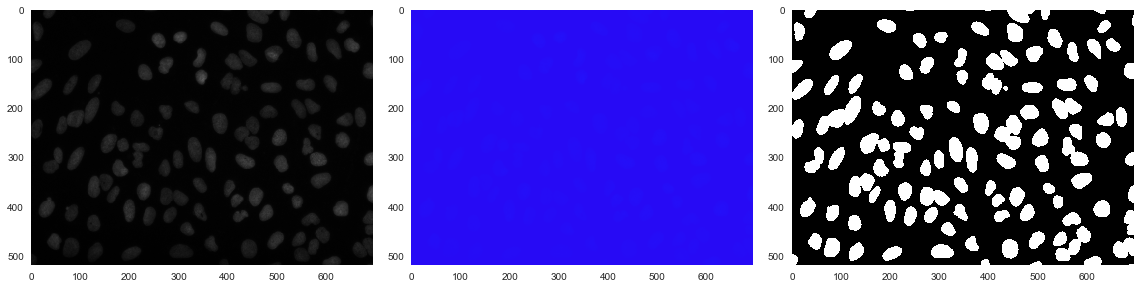

In [596]:
import torchvision.transforms as TT
#monkeypatch(dset, 'transform', train_transform)
#train_dset.transform=train_transform
#valid_dset.transform=train_transform

model.eval()

for img,(_,mask) in iter(train_loader):
    break


pred = model(Variable(img,requires_grad=False))
color_adjust = model.get_color_adjust(Variable(img,requires_grad=False))
coarse = model.get_coarse(Variable(img,requires_grad=False))

show_images([img[0],color_adjust.data[0],mask[0]])
#show_images([img[0],coarse[0].data[0],coarse[1].data[0],coarse[2].data[0],mask[0]])
#show_images([img[0],pred.data[0],mask[0]])

#pred = ToPILImage()(pred.data[0])
#ii = np.array(pred.data[0].squeeze())
#plt.imshow(ii,cmap='gray')
#ii[abs(ii-0.1425)<=0.01]=1
#ii=mask[0]
#print ii.min(), ii.max(), ii.mean(), stats.mode(ii.flatten())
#show_images([img[0],pred.data[0],mask[0]])
#print criterion(pred,Variable(mask))
#print ((pred.data[0]-mask[0])* (pred.data[0]-mask[0])).sum()/pred.data[0].numel()
#print ((mask[0]-mask[0].mean())* (mask[0]-mask[0].mean())).sum()/mask[0].numel()
#print pred.data[0].size()
#plot_img_and_hist(pred.data[0])
#plot_img_and_hist([img,mask])
#mask.mean()
#mask.shape
#show_img([img,mask])
#train_dset.transform
#train_dset.transform=transforms.ToTensor()
#train_dset.transform
#TT.ToPILImage()(img)
#show_images(pred.data[0])
#plt.imshow(ToPILImage()(pred.data[0]))
#plt.imshow(pred.data[0].numpy().squeeze())
#plt.imshow(img_as_float(pred.data[0].numpy().squeeze()))

#print isinstance(pred.data[0], torch.Tensor)


#print baseline(train_loader, valid_loader, criterion, 1000)
#def is_inverted(img,invert_thresh_pd=10.0):
#    img_grey = img_as_ubyte(rgb2grey(img))
#    img_th = cv2.threshold(img_grey,0,255,cv2.THRESH_OTSU)[1]
#    return np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))

#print is_inverted(train_dset.data_df['images'].iloc[0])
#x = train_dset.data_df['images'].map(is_inverted)
#print np.where(train_dset.data_df['inv'])
#ii = train_dset.data_df['images'].iloc[71]
#plt.imshow(rgb2grey(ii),cmap='binary')
#plt.imshow(ii[:10,:10]-5)
#ii[:10,:10]

#show_images(rgb2grey(ii))

#plot_img_and_hist(rgb2grey(ii))
#train_dset.data_df['id'].iloc[71]
#print ii.dtype, ii.mean(), ii.max(), ii.min(), stats.mode(ii.flatten())
#plt.imshow(ii)

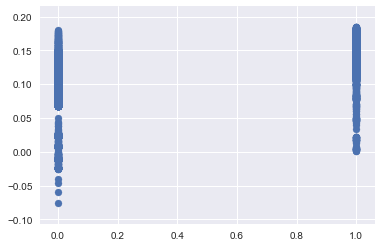

In [582]:
# pixel correlation plot
x=pred.data[0].numpy().flatten()
y=mask[0].numpy().flatten()
plt.scatter(y,x)
plt.show()

In [ ]:
epoch,stats=load_model(model, optimizer)
print epoch, stats

# Calculate IOU

In [613]:
#loss=reload(loss)
import scipy
from tqdm import tqdm
#post_process=reload(post_process)
import loss
import post_process
from post_process import parametric_pipeline
from loss import iou_metric, diagnose_errors, show_compare_gt
#model.eval()
#pred = [(model(Variable(img,requires_grad=False)).data.numpy().squeeze(), mask.numpy().squeeze()) for img, (mask,mask_seg) in tqdm(iter(train_loader))]
#pred = [(ToPILImage()(img.squeeze()),mask.numpy().squeeze()) for img, (mask,mask_seg) in iter(valid_loader)]
#img_th = [(parametric_pipeline(rgb2grey(np.asarray(img)),circle_size=4), mask) for img, mask in pred]
#ious = [iou_metric(i,m) for (i,m) in img_th]
print np.mean(ious),np.median(ious)
#diagnose_errors(img_th[0][0],img_th[0][1])
#show_compare_gt(pred[2][0],pred[2][1],circle_size=10)
#print pred[0][0].dtype
#pred[0]

0.158894834172 0.114834653566


In [ ]:
dice 0.239599661927 0.221256282842
jaccard 0.23728979728 0.189091591261
bce 0.279290088953 0.217723006553
mse 0.304971608193 0.309523258999
new arch
mse 0.158894834172 0.114834653566
bce mean = 0.17207, med = 0.12120
dice mean = 0.24912, med = 0.19799
img-weighted bce 0.22999, med = 0.18525

In [82]:
###### dset.data_df['masks_unlabeled']=dset.data_df['masks_unlabled']

#for i,(img,mask) in enumerate(valid_loader):
#    break

#print mask[1].dtype
#dset.data_df['masks'].iloc[0].max()
#ii=np.array(((1,2,3),(4,5,5)),dtype=np.uint8)
#print torch.from_numpy(ii)
img=dset.data_df['images'].iloc[0]
m1=dset.data_df['masks'].iloc[0]
m2=dset.data_df['masks_seg'].iloc[0]
ii,mm1,mm2=train_transform(img,m1,m2)
print mm1.shape,mm2.shape

before (256, 256, 3) (256, 256, 1) (256, 256, 1)
k 1
after (256, 256, 3) (256, 256, 1) (256, 256, 1)
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


In [28]:
ii=np.zeros((2,3,1))
print np.flip(ii,2).shape

(2, 3, 1)


In [43]:
np.rot90

2


In [603]:
print stats

[(10, 0.1508605394512415, 0.14138794186360695), (20, 0.06947005353868008, 0.13381062616484568), (30, 0.060165710374712945, 0.12511444675243077), (40, 0.03398673869669437, 0.11621393918689779), (50, 0.0153909264318645, 0.10906757881371852), (60, 0.0230019719650348, 0.10420079410130925), (70, 0.015239033102989196, 0.10103696699747268), (80, 0.016849563806317747, 0.10080118066466906), (90, 0.017663979964951674, 0.10382523825939964), (100, 0.015023434832692147, 0.10746573925237446), (110, 0.012301610748876224, 0.10788909625262022)]


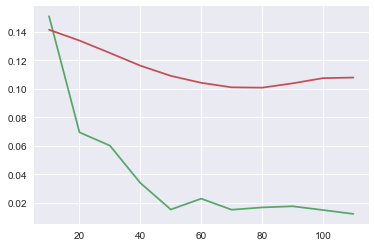

In [612]:
import matplotlib.pyplot as plt
import operator
from operator import itemgetter

xs = map(itemgetter(0), stats)
ys = map(itemgetter(1), stats)
zs = map(itemgetter(2), stats)


fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(xs,ys,'g')
ax.plot(xs,zs,'r')
plt.show()
#fig.savefig('path/to/save/image/to.png')   # save the figure to file
#plt.close(fig)    # close the figure
#print xs

In [622]:
x=pd.DataFrame({'x':[1,2,3,4],'y':[1,2,3,4]})
x['x'].map(lambda x: x + 1)
#x['x'].map(lambda x: x + 1)
[x+1 for x in tqdm(x['x'])]

100%|██████████| 4/4 [00:00<00:00, 11358.98it/s]


[2, 3, 4, 5]

In [616]:
x

,x,y
0,1,1
1,2,2
2,3,3
3,4,4
